In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py

--2022-02-20 22:12:57--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.70K  --.-KB/s    in 0s      

2022-02-20 22:12:57 (43.2 MB/s) - ‘visualization.py’ saved [13008/13008]



In [3]:
from visualization import plot_conf_mat

In [4]:
def plot_conf(y_test, y_pred, class_names):
  cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot()
  plt.show()

In [5]:
path = "https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned_without_rodage_u.csv" # path for the preprocessed datadet
!wget $path

--2022-02-20 22:13:07--  https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned_without_rodage_u.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3717640 (3.5M) [text/plain]
Saving to: ‘dataset_cleaned_without_rodage_u.csv’

dataset_cleaned_wit 100%[===================>]   3.54M  --.-KB/s    in 0.09s   

2022-02-20 22:13:09 (40.0 MB/s) - ‘dataset_cleaned_without_rodage_u.csv’ saved [3717640/3717640]



In [6]:
df = pd.read_csv("dataset_cleaned_without_rodage_u.csv", index_col="PROC_TRACEINFO")

In [7]:
df.head()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value_exp,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,results
PROC_TRACEINFO,,,,,,,,,,,,,
I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,460468.625050,12.16,1,6.62,26.37,18.8,109.62,6.60,0
I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,498819.706587,12.19,0,6.41,21.03,18.5,105.48,6.40,0
I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,384615.725794,12.24,1,6.62,25.81,17.5,100.03,6.61,0
I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,369534.727474,12.35,0,6.62,24.62,15.6,104.94,6.61,0
I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,474491.982426,12.19,1,6.62,29.22,33.6,99.19,6.61,0


# Binary Classification

We have only two classes: the engine pass the test or not. $results$ is 0 for a success and 1 for a failure.

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

features = list(df.columns)[:-1]

X_train = df_train[features]
X_test = df_test[features]
y_train = df_train["results"]
y_test = df_test["results"]

Let's try Logistic Regression with no regularization first (  $C<<1$  )

In [9]:
model = LogisticRegression(C=1e-9, multi_class="multinomial")
model.fit(X_train, y_train)

LogisticRegression(C=1e-09, multi_class='multinomial')

In [10]:
y_pred_proba = model.predict_proba(X_test)
y_pred_proba

array([[0.99520464, 0.00479536],
       [0.99613673, 0.00386327],
       [0.9959182 , 0.0040818 ],
       ...,
       [0.99613682, 0.00386318],
       [0.98903488, 0.01096512],
       [0.99494534, 0.00505466]])

In [11]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
accuracy_score(y_test, y_pred)

0.9902940750398378

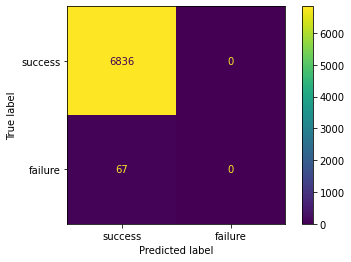

In [15]:
class_names = ["success", "failure"]
plot_conf(y_test, y_pred, class_names)

Even if the accuracy score is very high, our model makes a lot of mistakes because it never predicts failures.


# Normalization

In [27]:
def MyMultinomialRegression(C=1e-9):
    return make_pipeline(
        StandardScaler(),
        LogisticRegression(C=C, multi_class="multinomial")
    )

In [30]:
model = MyMultinomialRegression(C=1)
model.fit(X_train_balanced, y_train_balanced)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, multi_class='multinomial'))])

Normalized confusion matrix
[[0.6423347  0.3576653 ]
 [0.47761194 0.52238806]]


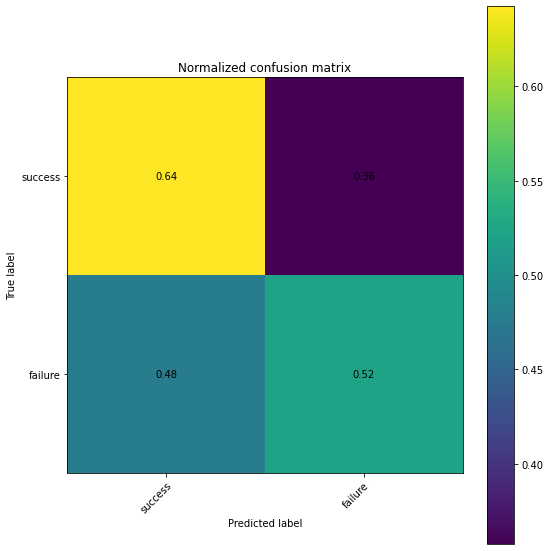

In [31]:
y_pred = model.predict(X_test)
# plot_conf(y_test, y_pred, class_names)

plot_conf_mat(y_test, y_pred, np.array(class_names))

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [17]:
model = LogisticRegression(C=1, multi_class="multinomial")
model.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)

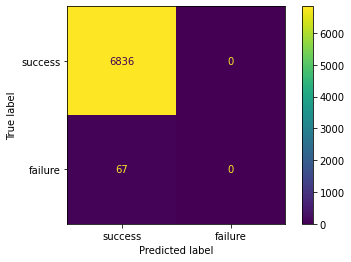

In [18]:
plot_conf(y_test, y_pred, class_names)

# SMOTE

In [19]:
df["results"].sum()/len(df["results"])*100

0.8836737650296972

Only 0.9% of our dataset is labeled as failure. So, an idea is to use SMOTE (Synthetic Minority Over-sampling Technique) to have classes that are more balanced.

In [20]:
smote = SMOTE()

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
pd.value_counts(y_train_balanced)

0    27374
1    27374
Name: results, dtype: int64

Normalized confusion matrix
[[0.59918081 0.40081919]
 [0.50746269 0.49253731]]


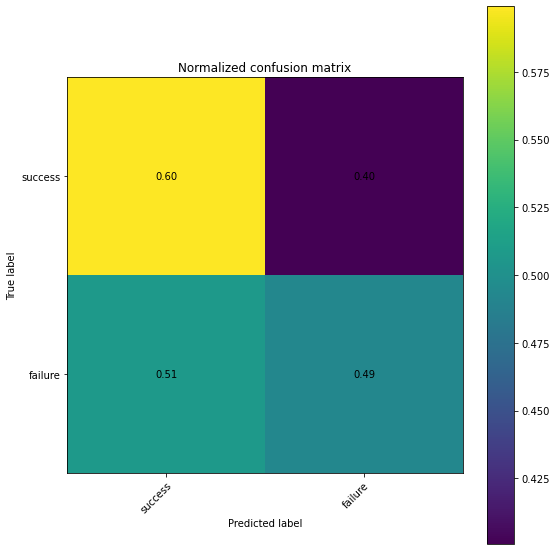

In [24]:
# model = LogisticRegression(C=1)
model = LogisticRegression(C=1, solver='liblinear')
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
# plot_conf(y_test, y_pred, class_names)

plot_conf_mat(y_test, y_pred, np.array(class_names))

In [32]:
accuracy_score(y_test, y_pred)

0.6411705055772853

We have more failures that are predicted but the problem is we now have a lot ot success that are predicted as failures.

Moreover, the accuracy has decreased.

# Grid Search
find the best regularization weight ```C```

In [33]:
GridSearchCV(MyMultinomialRegression(), [] ).get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__standardscaler', 'estimator__logisticregression', 'estimator__standardscaler__copy', 'estimator__standardscaler__with_mean', 'estimator__standardscaler__with_std', 'estimator__logisticregression__C', 'estimator__logisticregression__class_weight', 'estimator__logisticregression__dual', 'estimator__logisticregression__fit_intercept', 'estimator__logisticregression__intercept_scaling', 'estimator__logisticregression__l1_ratio', 'estimator__logisticregression__max_iter', 'estimator__logisticregression__multi_class', 'estimator__logisticregression__n_jobs', 'estimator__logisticregression__penalty', 'estimator__logisticregression__random_state', 'estimator__logisticregression__solver', 'estimator__logisticregression__tol', 'estimator__logisticregression__verbose', 'estimator__logisticregression__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_sco

In [34]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=5)

parameters_to_test = [{ 'logisticregression__C': [10**i for i in range(-9, 5)] }]

# The different scoring metrics available are in:
#     https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
grid = GridSearchCV(MyMultinomialRegression(), parameters_to_test, cv=k_fold, scoring='f1_macro')

In [35]:
grid.fit(X_train_balanced, y_train_balanced)
print("The best regularization weigth is ", grid.best_params_)

The best regularization weigth is  {'logisticregression__C': 10}


              precision    recall  f1-score   support

           0       0.99      0.64      0.78      6836
           1       0.01      0.52      0.03        67

    accuracy                           0.64      6903
   macro avg       0.50      0.58      0.40      6903
weighted avg       0.98      0.64      0.77      6903

Normalized confusion matrix
[[0.6423347  0.3576653 ]
 [0.47761194 0.52238806]]


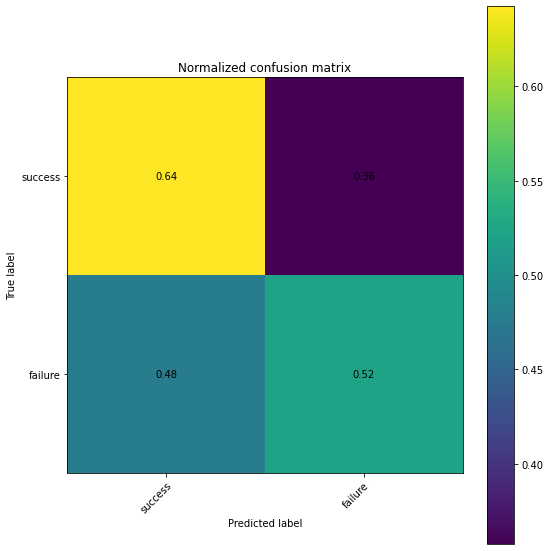

In [37]:
model = grid.best_estimator_
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_conf_mat(y_test, y_pred, np.array(class_names))